# DATA 608 Assignment 5: What Is The Effect Of The Earth's Temperature on Cyclonic Storms?

Historic data indicates that the occurrence and intensity of cyclonic storms (Hurricanes, Typhoons and Tornados) increases with the increased earth temperature. 

For this assignment you will need to tell this story to a non-technical audience (eg: a high-school earth science class)

Data Set Links:

* https://www.statista.com/statistics/276629/global-co2-emissions/#:~:text=Global%20carbon%20dioxide%20emissions%20from,by%20more%20than%2060%20percent

* https://climate.nasa.gov/vital-signs/carbon-dioxide/

* https://climate.nasa.gov/vital-signs/global-temperature/

* https://www.nasa.gov/stem-content/sea-level-height-data-set/

* https://gml.noaa.gov/ccgg/trends/gl_gr.html



In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as dates
import datetime

# Data Sources

In [2]:
# load the data set for both land and ocean anomalies
anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/anomalies_data.csv'
ocean_anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/ocean_temp_anomalies.csv'
land_anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/land_temp_anomalies.csv'

land_ocean_anomalies_data = pd.read_csv(anomalies_url)
ocean_anomalies_data = pd.read_csv(ocean_anomalies_url)
land_anomalies_data = pd.read_csv(land_anomalies_url)

# load the hurricane data set and remove uncessary columns
hur_data_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2023-051124.txt'
hurricane_raw_data = pd.read_csv(hur_data_url, sep = ',').reset_index()
hurricane_raw_data = hurricane_raw_data.drop(['AL011851', '            UNNAMED', '     14', 'Unnamed: 3','level_7',
                                               'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 
                                              'level_13', 'level_14', 'level_15', 'level_16'], axis=1)

# load the us tornadoes data set
tornadoes_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/us_tornadoes.csv'
tornadoes_data = pd.read_csv(tornadoes_url)

# load the carbon dioxide data set
carbon_dioxide_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/carbon_dioxide_anomalies.csv'
carbon_dioxide_growth_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/carbon_dioxide_growth_annual.csv'

carbon_dioxide_data = pd.read_csv(carbon_dioxide_url)
carbon_dioxide_growth_data = pd.read_csv(carbon_dioxide_growth_url)

# Data Preparation
### Temperature Anomalies (Land and Ocean)

In [3]:
# rename columns on earth anomalies data
land_ocean_anomalies_data = land_ocean_anomalies_data.rename(columns={'Year': 'year', 'Anomaly': 'Land & Ocean Anomaly'})
ocean_anomalies_data = ocean_anomalies_data.rename(columns={'Anomaly': 'Ocean Anomaly'})
land_anomalies_data = land_anomalies_data.rename(columns={'Anomaly': 'Land Anomaly'})

# combine all temperature change
overall_temp_change = land_ocean_anomalies_data.merge(ocean_anomalies_data, how='left', on = 'year')
overall_temp_change = overall_temp_change.merge(land_anomalies_data, how='left', on = 'year')
overall_temp_change['year'] = pd.to_datetime(overall_temp_change['year'], format='%Y')
overall_temp_change

,year,Land & Ocean Anomaly,Ocean Anomaly,Land Anomaly
0,1999-01-01,0.44,0.50,0.89
1,2000-01-01,0.43,0.30,0.62
2,2001-01-01,0.48,0.34,0.62
3,2002-01-01,0.64,0.46,0.82
4,2003-01-01,0.60,0.48,0.95
5,2004-01-01,0.58,0.51,0.88
6,2005-01-01,0.66,0.49,0.76
7,2006-01-01,0.66,0.48,1.12
8,2007-01-01,0.69,0.49,1.11
9,2008-01-01,0.52,0.38,1.06


### Carbon Dioxide

In [4]:
# extract the last 25 years of carbon dioxide growth data
carbon_last_25 = carbon_dioxide_growth_data.loc[carbon_dioxide_growth_data['year'] >= 1999].drop(['unc'], axis=1)
carbon_dioxide_growth_data = land_ocean_anomalies_data.merge(carbon_last_25, how = 'left', on = 'year')

carbon_dioxide_growth_data

,year,Land & Ocean Anomaly,mean
0,1999,0.44,368.54
1,2000,0.43,369.71
2,2001,0.48,371.32
3,2002,0.64,373.45
4,2003,0.60,375.98
5,2004,0.58,377.70
6,2005,0.66,379.98
7,2006,0.66,382.09
8,2007,0.69,384.02
9,2008,0.52,385.83


In [5]:
# carbon dioxide monthly average emission
carbon_dioxide_data = pd.read_csv(carbon_dioxide_url)
carbon_dioxide_last25 = carbon_dioxide_data[carbon_dioxide_data['year'] >= 1999]
carbon_dioxide_last25['year'] = carbon_dioxide_last25['year'].astype(int).astype(str)
carbon_dioxide_last25 = carbon_dioxide_last25.drop(['de-season alized', 'number of days', 'standard deviation of days', 'unc of monthly mean', 'Unnamed: 7'], axis=1)

# carbon dioxide annual average
carbon_dioxide_data_annual25 = round(carbon_dioxide_last25.groupby(['year'])['monthly average'].sum(), 2).reset_index().sort_values(['year'])
carbon_dioxide_data_annual25 = carbon_dioxide_data_annual25.rename(columns={'monthly average': 'annual average'})
carbon_dioxide_data_annual25

/var/folders/h4/zjq554hs0b57vqfcrc5738wh0000gn/T/ipykernel_9922/41512285.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dioxide_last25['year'] = carbon_dioxide_last25['year'].astype(int).astype(str)


,year,annual average
0,1999,4422.48
1,2000,4436.49
2,2001,4455.83
3,2002,4481.43
4,2003,4511.80
5,2004,4532.38
6,2005,4559.80
7,2006,4585.09
8,2007,4608.30
9,2008,4629.98


### Tornado

In [6]:
# tornada clean up
tornadoes_data['year'] = tornadoes_data['Date'].astype(str).str[0:4]
tornadoes_25_data = tornadoes_data[tornadoes_data['year'].astype(int) >= 1999]
tornadoes_25_data = tornadoes_25_data.drop(['Date'], axis=1)
tornadoes_25_data['year'] = tornadoes_data['year'].astype(str)
land_anomalies_data['year'] = land_anomalies_data['year'].astype(str)

tornado_temp_data = land_anomalies_data.merge(tornadoes_25_data, how = 'left', on = 'year')
tornado_temp_data['year'] = tornado_temp_data['year'].astype(int)
tornado_temp_data['Tornadoes'] = tornado_temp_data['Tornadoes'].astype(int)
tornado_temp_data

,year,Land Anomaly,Tornadoes,Fatalities
0,1999,0.89,54,0
1,2000,0.62,47,2
2,2001,0.62,84,2
3,2002,0.82,61,0
4,2003,0.95,32,0
5,2004,0.88,296,8
6,2005,0.76,133,1
7,2006,1.12,84,1
8,2007,1.11,52,0
9,2008,1.06,111,2


### Hurricane

The hurricane data is sourced from NOAA Hurricane Database and is unstructured. Because of that, it needs to be transformed before loading it for data analysis and visualization. The anomalies data will be also be cleansed as well.

In [7]:
# create Saffir-Simpson Hurricane Scale function
def hurricane_scale(x):
    if 64 <= x['wind_speed'] <= 82:
        return 1
    elif 83 <= x['wind_speed'] <= 95:
        return 2
    elif 96 <= x['wind_speed'] <= 112:
        return 3
    elif 113 <= x['wind_speed'] <= 136:
        return 4
    elif x['wind_speed'] >= 137:
        return 5
    else:
        return 0

# create a dictionary and sort the data based on the storm ID and name
hurricane_raw_data_dict = hurricane_raw_data.to_dict(orient='record')
storm_id = None
storm_name = None
date_time = None
latitude = None
longtitude = None
wind_speed = None

hurricane_data = []

for data in hurricane_raw_data_dict:
    if data['level_0'].startswith('AL'):
        storm_id = data['level_0']
        storm_name = data['level_1']
    else:
        date_time = data['level_0']
        latitude = data['level_4']
        longtitude = data['level_5']
        wind_speed = data['level_6']

    hurricane_data.append({
        'storm_id': storm_id,
        'storm_name': storm_name,
        'date_time': date_time,
        'latitude': latitude,
        'longtitude': longtitude,
        'wind_speed': wind_speed
    })

# convert the dictionary back to a data frame
hurricane_data = pd.DataFrame(hurricane_data)
hurricane_data['date_time'] = pd.to_datetime(hurricane_data['date_time'], format='%Y-%m-%d')
hurricane_data['year'] = hurricane_data['date_time'].dt.year
hurricane_data['category'] = hurricane_data.apply(hurricane_scale, axis=1)

# extract the data starting from 1999 and group by
hurricane_25_data = hurricane_data[hurricane_data['year'] >= 1999]
hurricane_25_data_count = hurricane_25_data.groupby('year')['storm_id'].nunique().reset_index(name='counts')

# extract the count of high risk hurricanes
high_risk_hurricane = hurricane_25_data[hurricane_data['category'] >= 3]
high_risk_hurricane_count = high_risk_hurricane.groupby('year')['storm_id'].nunique().reset_index(name='counts')
hurricane_average_data = round(hurricane_25_data.groupby(['storm_name', 'year'])['wind_speed'].mean(), 2).reset_index().sort_values(['year'])
hurricane_average_data_count = hurricane_average_data.groupby('year').size().reset_index(name='counts')
hurricane_average_data_wind_speed = round(hurricane_25_data.groupby(['year'])['wind_speed'].mean(), 2).reset_index().sort_values(['year'])
hurricane_average_data_wind_speed

/var/folders/h4/zjq554hs0b57vqfcrc5738wh0000gn/T/ipykernel_9922/1336005465.py:17: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  hurricane_raw_data_dict = hurricane_raw_data.to_dict(orient='record')
/var/folders/h4/zjq554hs0b57vqfcrc5738wh0000gn/T/ipykernel_9922/1336005465.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_risk_hurricane = hurricane_25_data[hurricane_data['category'] >= 3]


,year,wind_speed
0,1999,57.76
1,2000,49.94
2,2001,47.27
3,2002,41.97
4,2003,49.89
5,2004,57.14
6,2005,49.68
7,2006,48.18
8,2007,43.72
9,2008,50.47


In [8]:
# combine hurricane wind speed and ocean anomaly data
hurricane_wind_data = hurricane_average_data_wind_speed.merge(ocean_anomalies_data, how='left', on = 'year')

# combine hurricane and ocean anomaly data
hurricane_temp_data = hurricane_25_data_count.merge(ocean_anomalies_data, how='left', on = 'year')

### Cyclonic Storms

In [9]:
# combine cyclonic storms counts and land and ocean anomalies
tornadoes_25_data2 = tornadoes_data
tornadoes_25_data2['year'] = tornadoes_data['year'].astype(int)
cyclone_temp_data = land_ocean_anomalies_data.merge(hurricane_average_data_count, how='left', on = 'year')
cyclone_temp_data = cyclone_temp_data.merge(tornadoes_25_data2, how='left', on = 'year' )
cyclone_temp_data = cyclone_temp_data.drop(['Date'], axis=1)
cyclone_temp_data = cyclone_temp_data.rename(columns={'counts':'Hurricane Counts', 'Tornadoes': 'Tornadoes Count'})
cyclone_temp_data['Cyclonic Storm Total'] = cyclone_temp_data['Hurricane Counts'] + cyclone_temp_data['Tornadoes Count']
cyclone_temp_data

,year,Land & Ocean Anomaly,Hurricane Counts,Tornadoes Count,Fatalities,Cyclonic Storm Total
0,1999,0.44,13.0,54,0,67.0
1,2000,0.43,16.0,47,2,63.0
2,2001,0.48,17.0,84,2,101.0
3,2002,0.64,14.0,61,0,75.0
4,2003,0.60,18.0,32,0,50.0
5,2004,0.58,17.0,296,8,313.0
6,2005,0.66,31.0,133,1,164.0
7,2006,0.66,12.0,84,1,96.0
8,2007,0.69,18.0,52,0,70.0
9,2008,0.52,18.0,111,2,129.0


# Data Visualization

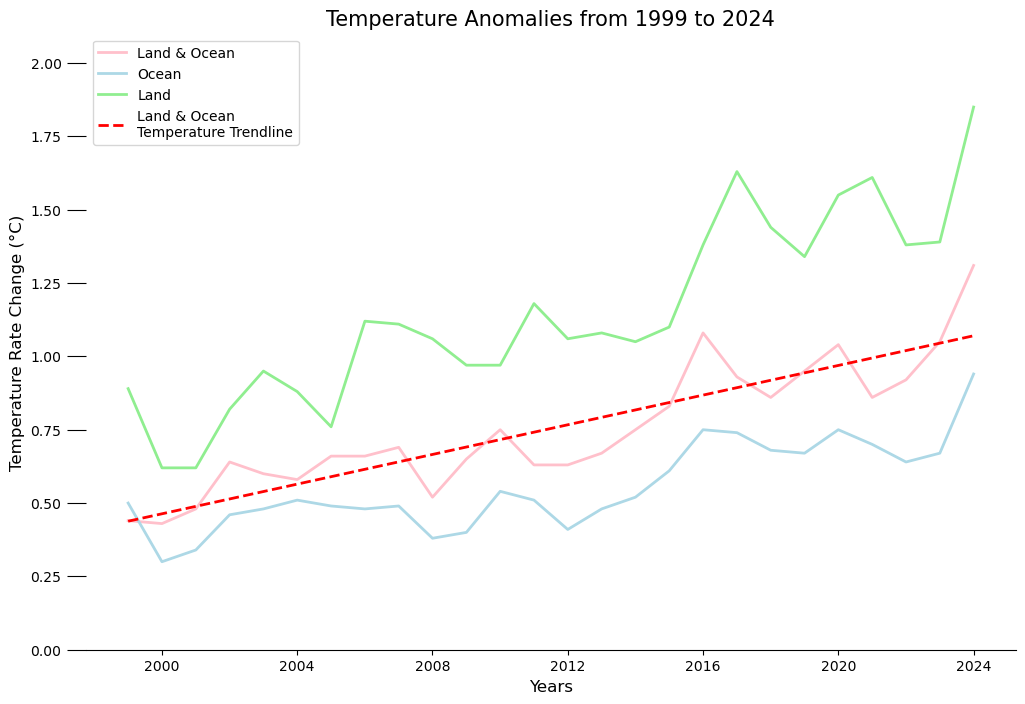

In [10]:
# overall trend on temperature anomalies
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(overall_temp_change['year'], overall_temp_change['Land & Ocean Anomaly'], color='pink', lw=2, label = 'Land & Ocean')
ax1.plot(overall_temp_change['year'], overall_temp_change['Ocean Anomaly'], color='lightblue', lw=2, label = 'Ocean')
ax1.plot(overall_temp_change['year'], overall_temp_change['Land Anomaly'], color='lightgreen', lw=2, label = 'Land')

# set the trendline
x = overall_temp_change['year']
x_num = dates.date2num(x)
trend = np.polyfit(x_num, overall_temp_change['Land & Ocean Anomaly'], 1)
fit = np.poly1d(trend)
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label = 'Land & Ocean \nTemperature Trendline', lw = 2)

# x and y label
ax1.set_ylabel('Temperature Rate Change (°C)', color='black', fontsize=12)
ax1.set_xlabel('Years', color='black', fontsize=12)
ax1.tick_params(axis="y", labelcolor='black', size = 14)
ax1.set_ylim(0,2.1)
ax1.legend(bbox_to_anchor=(1.3,.47),loc='lower right', frameon=False)
sns.despine(left= True, right = True)

plt.title('Temperature Anomalies from 1999 to 2024', size = 15)
plt.legend()

plt.savefig('Temperature Change in past 25 Years.png')
plt.show()

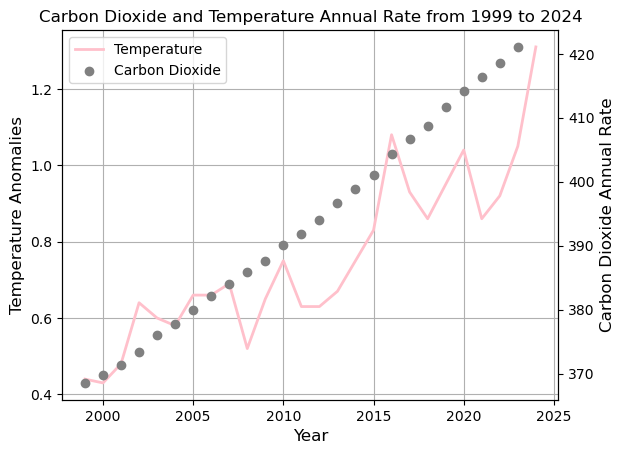

In [11]:
# line and scatter graph on carbon dioxide and temperature anomalies annual change
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(carbon_dioxide_growth_data['year'], carbon_dioxide_growth_data['Land & Ocean Anomaly'], color='pink', lw=2, label = 'Temperature')
ax3 = ax2.twinx()
ax3.scatter(carbon_dioxide_growth_data['year'], carbon_dioxide_growth_data['mean'], color='gray', label = 'Carbon Dioxide')
plt.title('Carbon Dioxide and Temperature Annual Rate from 1999 to 2024', size = 12)
ax2.grid()

# customize both x and y labels
ax2.set_xlabel('Year', size = 12)
ax2.set_ylabel('Temperature Anomalies', size = 12)
ax3.set_ylabel('Carbon Dioxide Annual Rate', size = 12)
lns1, lab1 = ax2.get_legend_handles_labels()
lns2, lab2 = ax3.get_legend_handles_labels()
ax2.legend(lns1 + lns2, lab1 + lab2, loc=0)

plt.savefig('Correlation between Temperature Anomalies and Carbon Dioxide Rate.png')
plt.show()

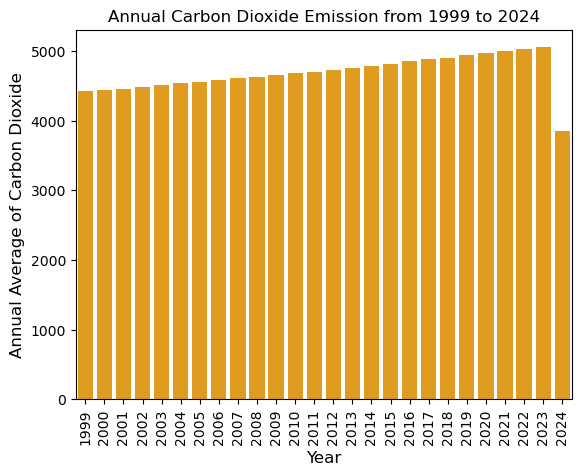

In [12]:
# bar graph on carbon dioxide emission
fig, ax3 = plt.subplots()
sns.barplot(x = carbon_dioxide_data_annual25['year'], y = carbon_dioxide_data_annual25['annual average'], color='orange', ax = ax3)

plt.title('Annual Carbon Dioxide Emission from 1999 to 2024', size = 12)

# customize both x and y labels
ax3.set_xlabel('Year', size = 12)
ax3.set_ylabel('Annual Average of Carbon Dioxide', size = 12)
plt.xticks(rotation=90)

plt.savefig('Annual Carbon Dioxide Emission.png')
plt.show()

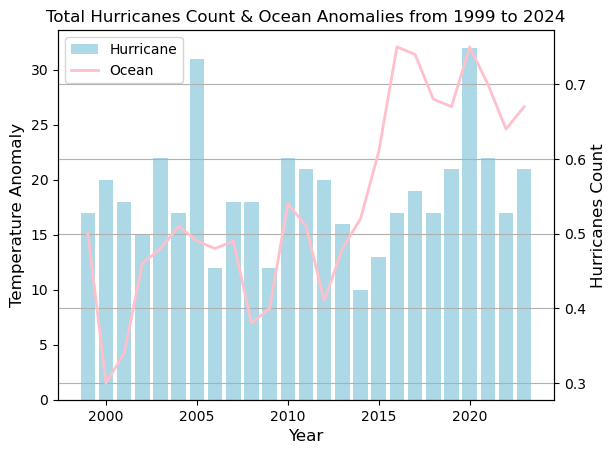

In [13]:
# line and bar graph on high hurricane count and temperature change
fig = plt.figure()
ax4 = fig.add_subplot(111)
ax4.bar(hurricane_temp_data['year'], hurricane_temp_data['counts'], color='lightblue', lw=2, label = 'Hurricane')
ax5 = ax4.twinx()
ax5.plot(hurricane_temp_data['year'], hurricane_temp_data['Ocean Anomaly'], color='pink', lw=2, label = 'Ocean')
ax5.grid()

# customize both x and y labels
plt.title('Total Hurricanes Count & Ocean Anomalies from 1999 to 2024', size = 12)
ax4.set_xlabel('Year', size = 12)
ax4.set_ylabel('Temperature Anomaly', size = 12)
ax5.set_ylabel('Hurricanes Count', size = 12)

lns3, lab3 = ax4.get_legend_handles_labels()
lns4, lab4 = ax5.get_legend_handles_labels()
ax4.legend(lns3 + lns4, lab3 + lab4, loc=0)

plt.savefig('Correlation between Ocean Anomaly and Hurricanes.png')
plt.show()

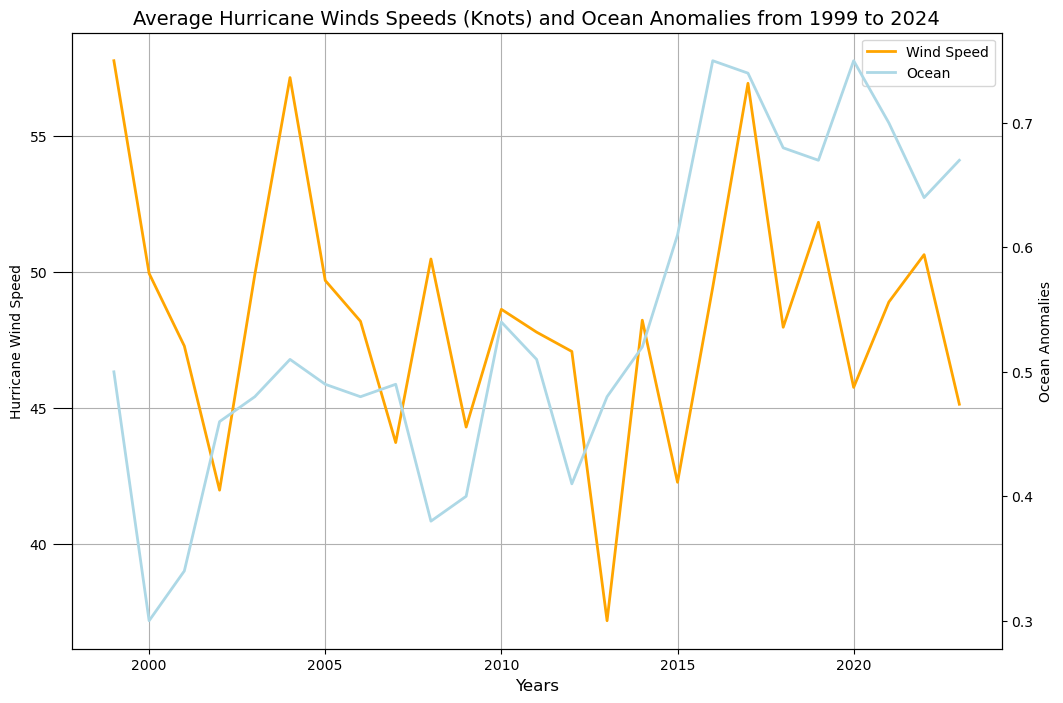

In [14]:
# line graph on hurricane wind speed and temperature change
fig, ax6 = plt.subplots(figsize=(12, 8))
ax6.plot(hurricane_wind_data['year'], hurricane_wind_data['wind_speed'], color='orange', lw=2, label = 'Wind Speed')
ax7 = ax6.twinx()
ax7.plot(hurricane_wind_data['year'], hurricane_wind_data['Ocean Anomaly'], color='lightblue', lw=2, label = 'Ocean')
ax6.grid()

# x and y label
ax6.set_ylabel('Hurricane Wind Speed', color='black', fontsize=10)
ax6.set_xlabel('Years', color='black', fontsize=12)
ax6.tick_params(axis='y', labelcolor='black', size = 14)
ax7.set_ylabel('Ocean Anomalies', color='black', fontsize=10)
lns5, lab5 = ax6.get_legend_handles_labels()
lns6, lab6 = ax7.get_legend_handles_labels()
ax6.legend(lns5 + lns6, lab5 + lab6, loc=0)

plt.title('Average Hurricane Winds Speeds (Knots) and Ocean Anomalies from 1999 to 2024', size = 14)
plt.savefig('Correlation between Ocean Anomaly and Winds Speed.png')
plt.show()

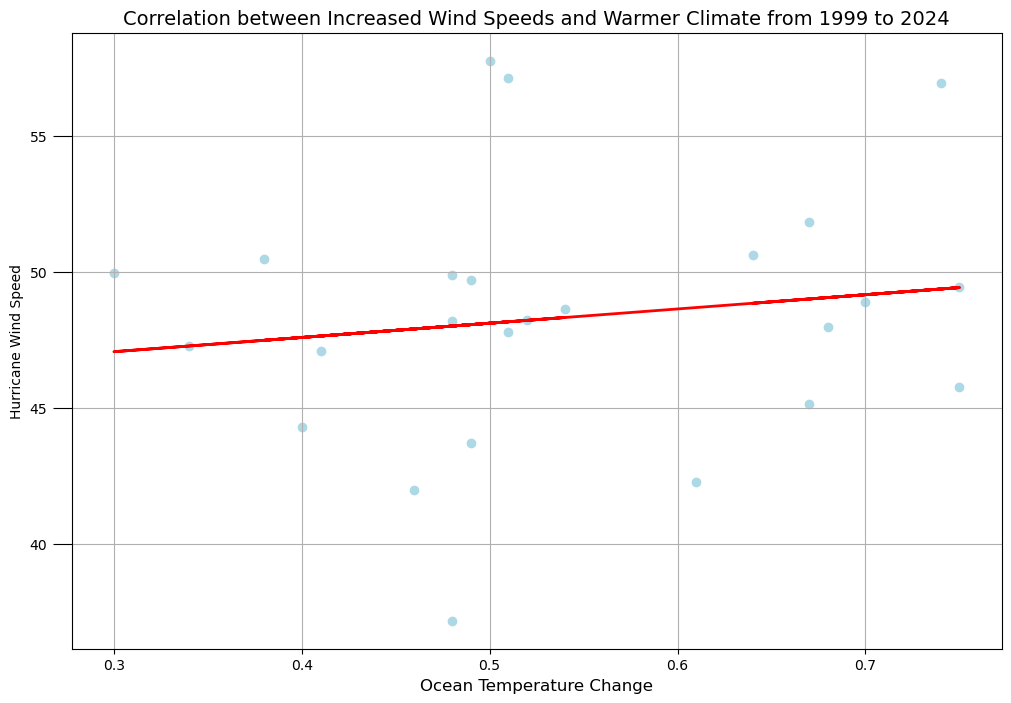

In [15]:
# scatter plot on winds and speed and ocean anomalies
fig, ax8 = plt.subplots(figsize=(12, 8))
ax8.scatter(hurricane_wind_data['Ocean Anomaly'], hurricane_wind_data['wind_speed'], color = 'lightblue')
ax8.grid()

# set the trendline
warm_trend = np.polyfit(hurricane_wind_data['Ocean Anomaly'], hurricane_wind_data['wind_speed'], 1)
trend_line = np.poly1d(warm_trend)
plt.plot(hurricane_wind_data['Ocean Anomaly'],trend_line(hurricane_wind_data['Ocean Anomaly']),"r", lw = 2)

# x and y label
ax8.set_ylabel('Hurricane Wind Speed', color='black', fontsize=10)
ax8.set_xlabel('Ocean Temperature Change', color='black', fontsize=12)
ax8.tick_params(axis='y', labelcolor='black', size = 14)

plt.title('Correlation between Increased Wind Speeds and Warmer Climate from 1999 to 2024', size = 14)
plt.savefig('Correlation between Increased Wind Speeds and Warmer Temperature.png')

plt.show()

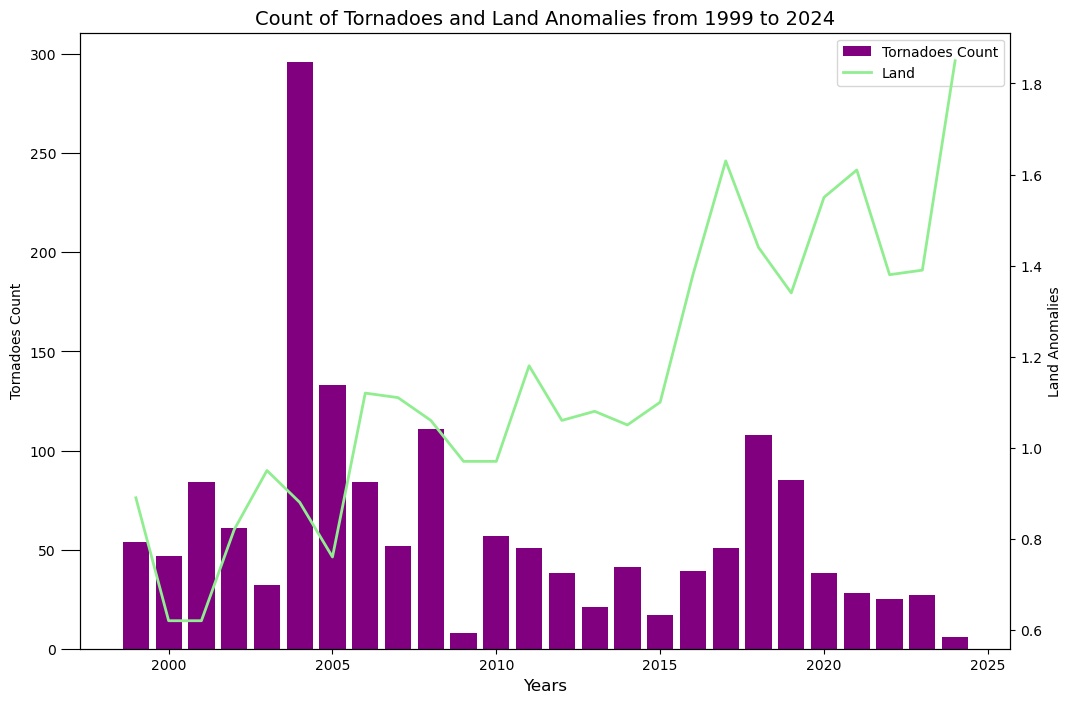

In [16]:
# line graph on hurricane wind speed and temperature change
fig, ax9 = plt.subplots(figsize=(12, 8))
ax9.bar(tornado_temp_data['year'], tornado_temp_data['Tornadoes'], color='purple', lw=2, label = 'Tornadoes Count')
ax10 = ax9.twinx()
ax10.plot(tornado_temp_data['year'], tornado_temp_data['Land Anomaly'], color='lightgreen', lw=2, label = 'Land')

# x and y label
ax9.set_ylabel('Tornadoes Count', color='black', fontsize=10)
ax9.set_xlabel('Years', color='black', fontsize=12)
ax9.tick_params(axis='y', labelcolor='black', size = 14)
ax10.set_ylabel('Land Anomalies', color='black', fontsize=10)
lns7, lab7 = ax9.get_legend_handles_labels()
lns8, lab8 = ax10.get_legend_handles_labels()
ax9.legend(lns7 + lns8, lab7 + lab8, loc=0)

plt.title('Count of Tornadoes and Land Anomalies from 1999 to 2024', size = 14)
plt.savefig('Correlation between Land Anomalies and Tornadoes Count.png')
plt.show()

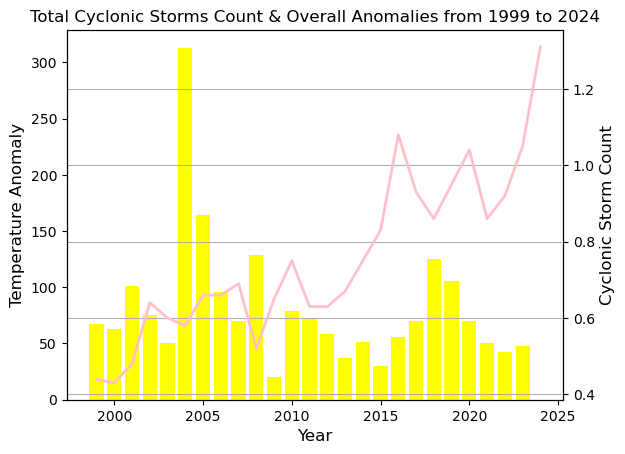

In [17]:
# line and bar graph on cyclone storm counts and temperature change
fig = plt.figure()
ax11 = fig.add_subplot(111)
ax11.bar(cyclone_temp_data['year'], cyclone_temp_data['Cyclonic Storm Total'], color='yellow', lw=2, label = 'Cyclonic Storms')
ax12 = ax11.twinx()
ax12.plot(cyclone_temp_data['year'], cyclone_temp_data['Land & Ocean Anomaly'], color='pink', lw=2, label = 'Land & Ocean')
ax12.grid()

# customize both x and y labels
plt.title('Total Cyclonic Storms Count & Overall Anomalies from 1999 to 2024', size = 12)
ax11.set_xlabel('Year', size = 12)
ax11.set_ylabel('Temperature Anomaly', size = 12)
ax12.set_ylabel('Cyclonic Storm Count', size = 12)

lns9, lab9 = ax11.get_legend_handles_labels()
lns10, lab10 = ax12.get_legend_handles_labels()
ax4.legend(lns9 + lns10, lab9 + lab10, loc=0)

plt.savefig('Total Cyclonic Counts.png')
plt.show()